# User Parameters

In [ ]:
Host = "colab" #@param ["colab", "AWS", "GCP"]

Account = "colab_datapirates" #@param["colab_datapirates", "colab_lahiru_cse", "colab_lahiru_personal"]
EMBEDDING_SIZE = 300 #@param [50, 150, 200, 250, 300, 350, 400, 450, 500]
embedding_type = "fasttext" #@param ["fasttext","word2vec"]
experiment_no = "1001" #@param [] {allow-input: true}
model_type = "LSTM" #@param ["RNN","GRU", "LSTM", "BiLSTM" ] 

stack_modeles = "" #@param ["","2","3"]
apply_CNN = False #@param {type:"boolean"}

model_name = model_type + "_model"
if(stack_modeles == "2" or stack_modeles == "3"):
  model_name = "stacked_" + model_name + "_" + stack_modeles
if(apply_CNN):
  model_name = "CNN_" + model_name 

print(model_name)

LSTM_model


# Folder Paths

In [ ]:

folder_path = None
if (Host == "AWS" ):
  folder_path = "../../../"
else:
  if (Account == "colab_datapirates"):
    folder_path = "/content/drive/My Drive/FYP/Sentiment Analysis/Implementation/"
  if (Account == "colab_lahiru_cse"):
      folder_path =  '/content/drive/My Drive/University/FYP/Sentiment Analysis/Implementation/'
  if (Account == "colab_lahiru_personal"):
      folder_path =  '/content/drive/My Drive/University/FYP/Sentiment Analysis/Implementation/'

lankadeepa_data_path = folder_path + 'corpus/new/preprocess_from_isuru/lankadeepa_tagged_comments.csv'
gossip_lanka_data_path = folder_path + 'corpus/new/preprocess_from_isuru/gossip_lanka_tagged_comments.csv'
# "corpus/new/preprocess_from_unicode_values/lankadeepa_tagged_comments.csv"
# "corpus/new/preprocess_from_unicode_values/gossip_lanka_tagged_comments.csv"

context = 5
word_embedding_path = folder_path + "word_embedding/"+embedding_type+"/source2_data_from_gosspiLanka_and_lankadeepa/"+str(EMBEDDING_SIZE)+"/"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
word_embedding_keydvectors_path = folder_path + "word_embedding/"+embedding_type+"/source2_data_from_gosspiLanka_and_lankadeepa/"+str(EMBEDDING_SIZE)+"/keyed_vectors/keyed.kv"
embedding_matrix_path = folder_path + 'Sentiment Analysis/CNN RNN/embedding_matrix/'+embedding_type+'_lankadeepa_gossiplanka_'+str(EMBEDDING_SIZE)+'_'+str(context)

experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" +str(experiment_no) + "_"+ model_name +"_"+embedding_type+"_"+str(EMBEDDING_SIZE)+"_"+str(context)
model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/"+str(experiment_no)+"_weights_best_"+model_name+"_"+embedding_type+"_"+str(experiment_no)+".hdf5"

# Dependencies

In [ ]:
# !pip install tensorflow==1.15.2
# !pip install q keras==2.3.1

In [ ]:
from __future__ import print_function
if (Host == "colab"):
  from google.colab import drive
  drive.mount('/content/drive')

import collections
import pickle
import re
import random
import sys
import os 
import time

import gensim
from gensim.models.keyedvectors import KeyedVectors
from gensim.models.fasttext import FastText
from gensim.models import word2vec

from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
from numpy import cumsum

import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential,Model,load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dropout, Activation, Flatten, \
    Embedding, Convolution1D, MaxPooling1D, AveragePooling1D, \
    Input, Dense, merge, Add,TimeDistributed, Bidirectional,SpatialDropout1D
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2, l1_l2
from keras.constraints import maxnorm
from keras import callbacks
from keras.utils import generic_utils,plot_model
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Data

In [ ]:
lankadeepa_data = pd.read_csv(lankadeepa_data_path)[:9059]
gossipLanka_data = pd.read_csv(gossip_lanka_data_path)
gossipLanka_data = gossipLanka_data.drop(columns=['Unnamed: 3'])

all_data = pd.concat([lankadeepa_data,gossipLanka_data], ignore_index=True)
all_data.shape

(15059, 3)

## Count Tokens

In [ ]:
# data_path = folder_path + "corpus/new/preprocess_from_isuru/gossip_lanka_all_comments.csv"
# # "corpus/new/preprocess_from_isuru/lankadeepa_comments_with_article_2.csv"
# data = pd.read_csv(data_path)

# def count_tokens(pandas_df):

#   count = 0
#   for index, row in pandas_df.iterrows():
#     comment_words,article_words = 0,0
#     if (type(row['comment']) == str) :
#       comment_words = len(row['comment'].split())
#     # if (type(row['article']) == str) :
#     #   article_words = len(row['article'].split())
#     count += (comment_words + article_words)
#   return count

# tokens = count_tokens(data)
# print(tokens)

In [ ]:
# all_data_path = folder_path + 
# "corpus/new/tagged_comments_all_with_punctuation_marks.csv" done
# "corpus/new/tagged_comments_all_with_punctuation_marks_question_only.csv"
# corpus/new/tagged_comments_all_without_punctuation_marks.csv

# all_data = pd.read_csv(all_data_path)

## Some other Preprocessing 

In [ ]:
# all_data['comment'] = all_data['comment'].str.replace('?', '')

In [ ]:
# all_data.to_csv(folder_path + 'corpus/new/tagged_comments_all_without_punctuation_marks.csv')

In [ ]:
# all_data['label'].value_counts()
# set(lankadeepa_data.comment.apply(list).sum())

# Create Input

## comment-label split

In [ ]:
# edit this later 
def text_preprocessing(train_data,test_data):
  train_data_texts = train_data['comment']
  train_data_labels = train_data['label']
  test_data_texts = test_data['comment']
  test_data_labels = test_data['label']


  comment_texts = []
  comment_labels = []

  train_text = []
  test_text = []
  train_labels=[]
  test_labels=[]

  for label in train_data_labels:
    if label == "POSITIVE":
      train_labels.append(1)
    else:
      train_labels.append(0)
  comment_labels.append(train_labels)

  for label in test_data_labels:
    if label == "POSITIVE":
      test_labels.append(1)
    else:
      test_labels.append(0)
  comment_labels.append(test_labels)
  

  for comment in train_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    train_text.append(lines)
  comment_texts.append(train_text)

  for comment in test_data_texts:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    test_text.append(lines)
  comment_texts.append(test_text)


  return comment_texts,comment_labels

# edit this later 
def text_preprocessing_1(data):
  comments = data['comment']
  labels = data['label']

  comments_splitted = []
  labels_encoded = []

  for label in labels:
    if label == "POSITIVE":
      labels_encoded.append(1)
    else:
      labels_encoded.append(0)

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)
  return comments_splitted,labels_encoded


def text_preprocessing_2(data):
  comments = data['comment']
  labels = data['label']

  comments_splitted = []

  for comment in comments:
    lines = []
    try:
      words = comment.split()
      lines += words
    except:
      continue
    comments_splitted.append(lines)

  return comments_splitted,labels

## Takenize and Split Data

In [ ]:
comment_texts, comment_labels = text_preprocessing_2(all_data)

# prepare tokenizer

t = Tokenizer()
t.fit_on_texts(comment_texts)
vocab_size = len(t.word_index) + 1
print(vocab_size)

60316


In [ ]:
encoded_docs = t.texts_to_sequences(comment_texts)

In [ ]:
max_length = len(max(encoded_docs, key=len))
padded_docs = pad_sequences(encoded_docs, maxlen=max_length)

comment_labels = np.array(comment_labels)
padded_docs = np.array(padded_docs)

In [ ]:
comment_labels = pd.get_dummies(comment_labels).values
print('Shape of label tensor:', comment_labels.shape)

Shape of label tensor: (15059, 4)


In [ ]:

X_train, X_test, y_train, y_test = train_test_split(padded_docs, comment_labels, test_size=0.1, random_state=0)


In [ ]:
(unique, counts) = np.unique(y_test, return_counts = True)
frequencies = np.asarray((unique, counts)).T
print(frequencies)

[[   0 4518]
 [   1 1506]]


# Word Embedding

## Generate Embedding Metrix

In [ ]:
def generate_embedding_metrix():
  if (embedding_type == 'fasttext'):
    word_embedding_model = FastText.load(word_embedding_path)
  else:
    word_embedding_model = word2vec.Word2Vec.load(word_embedding_path)
    
  word_vectors = word_embedding_model.wv
  word_vectors.save(word_embedding_keydvectors_path)
  word_vectors = KeyedVectors.load(word_embedding_keydvectors_path, mmap='r')

  embeddings_index = dict()
  for word, vocab_obj in word_vectors.vocab.items():
    embeddings_index[word]=word_vectors[word]

  # create a weight matrix for words in training docs
  embedding_matrix = zeros((vocab_size, embedding_size))
  for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

  pickle.dump(embedding_matrix, open(embedding_matrix_path, 'wb'))
  return embedding_matrix

## Load Embedding Matrix

In [ ]:
def load_word_embedding_atrix():
  f = open(embedding_matrix_path, 'rb')
  embedding_matrix= np.array(pickle.load(f))
  return embedding_matrix

# Models

## RNN(LSTM/GRU) model

In [ ]:
def RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN(hidden_dims)(embedding)

    x = Dense(hidden_dims, activation='relu', init='he_normal', 
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(4, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output ,name="RNN_model")

    model.compile(loss={'output':'categorical_crossentropy'},
              optimizer=Adadelta(lr=0.95, epsilon=1e-06),
              metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])
    
    print(model.summary())
    return model

def stacked_RNN_model_2(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(4, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "stacked_RNN_model_2")

    model.compile(loss={'output':'categorical_crossentropy'},
          optimizer=Adadelta(lr=0.95, epsilon=1e-06),
          metrics=["accuracy",
                       tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                       f1])

    print(model.summary())
    return model

def stacked_RNN_model_3(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    x = RNN_layer(hidden_dims,return_sequences=True)(embedding)
    x = RNN_layer(hidden_dims,return_sequences=True)(x)
    x = RNN_layer(hidden_dims)(x)

    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(4, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name="stacked_RNN_model_3")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    print(model.summary())
    return model

## CNN+RNN(LSTM /GRU) model 

In [ ]:
def CNN_RNN_model(RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2):
    main_input = Input(shape=(maxlen, ), dtype='int32', name='main_input')
    embedding  = Embedding(MAX_FEATURES, EMBEDDING_SIZE,
                  weights=[EMBEDDING_MATRIX], input_length=maxlen,
                  name='embedding' ,trainable=False)(main_input)

    embedding = Dropout(drop_out_value_1)(embedding)

    conv4 = Convolution1D(NB_FILTERS,
                          4,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv4')(embedding)
    maxConv4 = MaxPooling1D(pool_length=2,
                             name='maxConv4')(conv4)

    conv5 = Convolution1D(NB_FILTERS,
                          5,
                          border_mode='valid',
                          activation='relu',
                          subsample_length=1,
                          name='conv5')(embedding)
    maxConv5 = MaxPooling1D(pool_length=2,
                            name='maxConv5')(conv5)

    x = keras.layers.Concatenate(axis=1)([maxConv4, maxConv5])

    x = Dropout(drop_out_value_2)(x)

    x = RNN(rnn_output_size)(x)


    x = Dense(hidden_dims, activation='relu', init='he_normal',
              W_constraint = maxnorm(3), b_constraint=maxnorm(3),
              name='mlp')(x)

    x = Dropout(drop_out_value_2, name='drop')(x)

    output = Dense(4, init='he_normal',
                   activation='softmax', name='output')(x)

    model = Model(input=main_input, output=output, name= "CNN+RNN model")

    model.compile(loss={'output':'categorical_crossentropy'},
      optimizer=Adadelta(lr=0.95, epsilon=1e-06),
      metrics=["accuracy",
                    tf.keras.metrics.Precision(),
                    tf.keras.metrics.Recall(),
                    f1])

    return model

# Train and Evaluate Model

## Custom F1 Implementation

In [ ]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

## Train and Validate model

In [ ]:
def Train_Model_old(model,X_train, X_test, y_train, y_test):

  print('Training and Testing...')
  test_accs = []
  first_run = True


  acc=[]
  val_acc=[]
  loss=[]
  val_loss=[]
  best_val_acc = 0
  best_test_acc = 0
  for j in range(nb_epoch):
      a = time.time()
      his = model.fit(X_train, y_train,
                      batch_size=batch_size,
                      validation_data=[X_test, y_test],
                      shuffle=True,
                      epochs=1, verbose=verbosity)
      acc+=his.history['accuracy']
      val_acc+=his.history['val_accuracy']
      loss+=his.history['loss']
      val_loss+=his.history['val_loss']
      # print('Epoch %d/%d\t%s' % (j + 1, nb_epoch, str(his.history)))
      if his.history['val_accuracy'][0] >= best_val_acc:
          score, test_acc = model.evaluate(X_test, y_test,
                                      batch_size=batch_size,
                                      verbose=2)
          best_val_acc = his.history['val_accuracy'][0]
          best_test_acc = test_acc
          print('Got best epoch  best val acc is %f test acc is %f' %
                (best_val_acc, best_test_acc))
          if len(test_accs) > 0:
              print('Current avg test acc:', str(np.mean(test_accs)))
      b = time.time()
      cost = b - a
      left = (nb_epoch - j - 1)
      print('One round cost %ds, %d round %ds %dmin left' % (cost, left,
                                                            cost * left,
                                                            cost * left / 60.0))
      test_accs.append(best_test_acc)

  print('Avg test acc:', str(np.mean(test_accs)))
  return model

In [ ]:
def Train_Model(model,X_train, y_train, cross_validation = False):

  print('Training and Testing...')
  
  es = EarlyStopping(monitor='val_f1', mode='max', verbose=1, patience=5)
  checkpoint = ModelCheckpoint(model_save_path, monitor='val_f1', verbose=1, save_best_only=True, mode='max')
  callbacks_list = [checkpoint,es]

  if (cross_validation):
    callbacks_list = [es]

  his = model.fit(X_train, y_train, validation_split=VALIDATION_SPLIT, epochs=NB_EPOCHS, batch_size=BATCH_SIZE, callbacks=callbacks_list, verbose=1)
  return model,his

# Cross Validation

In [ ]:
def Do_Cross_Validation(X,y):

  # Define per-fold score containers
  loss_per_fold = []
  acc_per_fold = []
  precision_per_fold = []
  recall_per_fold = []
  f1_per_fold = []
  

  kfold = KFold(n_splits=FOLDS, shuffle=True)

  fold_no = 1
  inputs = X
  targets = y
  for train, test in kfold.split(inputs, targets):

    # model = build_model()
    model = RNN_model(GRU, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    
    # RNN_layer, maxlen, hidden_dims, l2_reg, drop_out_value_1, drop_out_value_2

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    model, his = Train_Model(model,inputs[train], targets[train], cross_validation=True)
 
    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)

    print(f"""Score for fold {fold_no}:
     {model.metrics_names[0]} of {scores[0]}; 
     {model.metrics_names[1]} of {scores[1]*100}% ;
     {model.metrics_names[2]} of {scores[2]*100}% ;
     {model.metrics_names[3]} of {scores[3]*100}% ;
     {model.metrics_names[4]} of {scores[4]*100}% ;
     """)
    
    loss_per_fold.append(scores[0])
    acc_per_fold.append(scores[1])
    precision_per_fold.append(scores[2])
    recall_per_fold.append(scores[3])
    f1_per_fold.append(scores[4])

    # Increase fold number
    fold_no = fold_no + 1

  # == Provide average scores ==
  print('------------------------------------------------------------------------')
  print('Score per fold')
  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f"""> Fold {i+1} - 
    Loss: {loss_per_fold[i]} - 
    Accuracy: {acc_per_fold[i]}% - 
    Precesion: {precision_per_fold[i]}% - 
    Recall: {recall_per_fold[i]}% - 
    F1: {f1_per_fold[i]}%
    """)
  print('------------------------------------------------------------------------')
  print('Average scores for all folds:')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Precision: {np.mean(precision_per_fold)}')
  print(f'> Recall: {np.mean(recall_per_fold)}')
  print(f'> F1: {np.mean(f1_per_fold)}')
  print('------------------------------------------------------------------------')

# Plot Graphs

In [ ]:
def Plot_graphs(metric,val_metric,metric_name):

  epochs=range(len(metric)) # Get number of epochs

  if metric_name == "accuracy":
    #------------------------------------------------
    # Plot training and validation accuracy per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation accuracy')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["Accuracy", "Validation Accuracy"])

    plt.figure()

  elif metric_name == "loss" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["Loss", "Validation Loss"])

    plt.figure()

  elif metric_name == "f1" :
    #------------------------------------------------
    # Plot training and validation loss per epoch
    #------------------------------------------------
    plt.plot(epochs, metric, 'r')
    plt.plot(epochs, val_metric, 'b')
    plt.title('Training and validation F1')
    plt.xlabel("Epochs")
    plt.ylabel("F1")
    plt.legend(["F1", "Validation F1"])

    plt.figure()


  # Expected Output
  # A chart where the validation loss does not increase sharply!

# Main Method

## Set Hyper-Parameters

In [ ]:
# EMBEDDING_MATRIX = generate_embedding_metrix()
EMBEDDING_MATRIX = load_word_embedding_atrix()

In [ ]:
MAX_FEATURES = EMBEDDING_MATRIX.shape[0] #vocab_size
VERBOSITY = 1
VALIDATION_SPLIT = 0.1
NB_EPOCHS = 10
FOLDS = 10

BATCH_SIZE = 32 # 64, 128
NB_FILTERS = 200
FILTER_LENGTH = 4 # test with 2,3,4,5
HIDDEN_DIMS = NB_FILTERS * 2
MAX_LEN = 210 #test with other values(only this value work for now)
DROPOUT_VALUE_1 = 0.5 #0.8 #0.3
DROPOUT_VALUE_2 = 0.5
L2_REG= 0.01

RNN = GRU

## Build and Compile Model

In [ ]:
def build_model() :
  model = None

  if (model_type == ("RNN" or "GRU" or "LSTM" )):
    # configure layer
    layer = None
    if (model_type == "RNN"):
      layer = RNN
    if (model_type == "GRU"):
      layer = GRU
    if (model_type == "LSTM"):
      layer = LSTM
    
    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_RNN_model_2(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_RNN_model_3(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = RNN_model(layer,MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

  elif (model_type == "BiLSTM" ):

    # configure architecture
    if (stack_modeles == "2"):
      model = stacked_BiLSTM_model_2(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (stack_modeles == "3"):
      model = stacked_BiLSTM_model_3(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    elif (apply_CNN):
      model = CNN_BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
    else :
      model = BiLSTM_model(MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)

    
  return model

## Train and Test Model (Holdout Method)

In [ ]:
# model = build_model()
model = stacked_RNN_model_3(LSTM, MAX_LEN, HIDDEN_DIMS, L2_REG, DROPOUT_VALUE_1, DROPOUT_VALUE_2)
plot_model(model,to_file="./model.png")

### Train Model

Training and Testing...
Train on 10843 samples, validate on 2711 samples
Epoch 1/10
10843/10843 [==============================] - 500s 46ms/step - loss: 1.2411 - accuracy: 0.5037 - f1: 0.3114 - val_loss: 1.2351 - val_accuracy: 0.5024 - val_f1: 0.4785

Epoch 00001: val_f1 improved from -inf to 0.47855, saving model to /content/drive/My Drive/FYP/Sentiment Analysis/Implementation/Sentiment Analysis/CNN RNN/saved_models/124_weights_best_LSTM_model_fasttext_124.hdf5
Epoch 2/10
10843/10843 [==============================] - 506s 47ms/step - loss: 1.2030 - accuracy: 0.5165 - f1: 0.3530 - val_loss: 1.1989 - val_accuracy: 0.5157 - val_f1: 0.2584

Epoch 00002: val_f1 did not improve from 0.47855
Epoch 3/10
10843/10843 [==============================] - 507s 47ms/step - loss: 1.1862 - accuracy: 0.5201 - f1: 0.3795 - val_loss: 1.2138 - val_accuracy: 0.5142 - val_f1: 0.0605

Epoch 00003: val_f1 did not improve from 0.47855
Epoch 4/10
10843/10843 [==============================] - 479s 44ms/step -

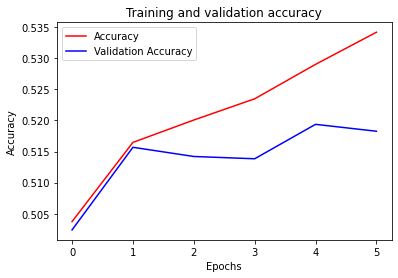

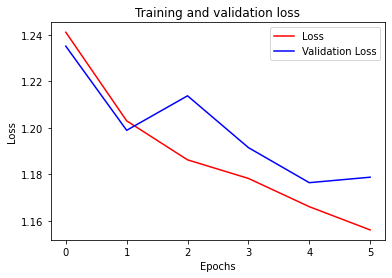

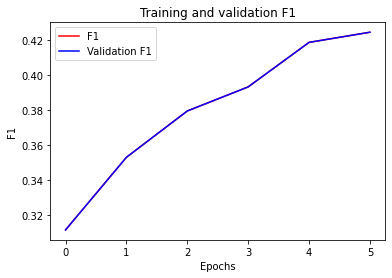

<Figure size 432x288 with 0 Axes>

In [ ]:
# trained_model = Train_Model_old(model,X_train, X_test, y_train, y_test)
trained_model, his = Train_Model(model,X_train, y_train, cross_validation = False)

accuracy = his.history['accuracy']
val_accuracy = his.history['val_accuracy']
loss = his.history['loss']
val_loss = his.history['val_loss']
f1 = his.history['f1']
val_f1 = his.history['f1']

Plot_graphs(accuracy,val_accuracy, "accuracy")
Plot_graphs(loss,val_loss, "loss")
Plot_graphs(f1,val_f1, "f1")

### Restart runtime and import Relibraries
There is a bug, if run time isn't restart after this point, It's going to malfunction.

In [ ]:
# # os.kill(os.getpid(), 9)

# exit()

In [ ]:
# from keras.models import Sequential,Model,load_model
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix,precision_recall_fscore_support

# experiment_no = 100
# model_name = "RNN"
# experiment_name = folder_path + "Sentiment Analysis/CNN RNN/experiments/" + model_name +str(experiment_no)+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(context)

# model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/weights_best_"+model_name+"_"+embedding_type+"_"+str(embedding_size)+"_"+str(experiment_no)+".hdf5"

### Test Model

#### Load Weights to Model

In [ ]:
model_save_path = folder_path + "Sentiment Analysis/CNN RNN/saved_models/111_weights_best_stacked_LSTM_3_fasttext_111.hdf5"

loaded_model  = load_model(model_save_path,custom_objects={"f1": f1}, compile=True)
print("loaded " + loaded_model.name)

# _, train_acc,train_f1 = loaded_model.evaluate(X_train, y_train, verbose=1)
# _, test_acc,test_f1= loaded_model.evaluate(X_test, y_test, verbose=1)
# print('Train_acc: %.3f, Test_acc: %.3f, Train_f1: %.3f,  Test_f1: %.3f' % (train_acc, test_acc,train_f1,test_f1))

loaded model_2


#### Get Predictions

In [ ]:
predictions = loaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1)

labels = np.argmax(y_test, axis=1)
predictions = np.argmax(predictions, axis=1)

# cm = confusion_matrix(labels,predictions )

# classification_report
report = classification_report(labels, predictions, digits=4,output_dict=True)
report_print = classification_report(labels, predictions, digits=4)
print(report_print)

# report_df = pd.DataFrame(report).transpose()
# report_df.to_csv(experiment_name+".csv")



1506/1506 [==============================] - 34s 23ms/step
              precision    recall  f1-score   support

           0     0.5453    0.8820    0.6739       771
           1     0.2136    0.0936    0.1302       235
           2     0.3125    0.1190    0.1724       294
           3     0.1591    0.0340    0.0560       206

    accuracy                         0.4940      1506
   macro avg     0.3076    0.2822    0.2581      1506
weighted avg     0.3953    0.4940    0.4067      1506



In [ ]:
# DataTagged_Original = pd.read_csv(all_data_path)
DataTagged_Original = pd.concat([lankadeepa_data,gossipLanka_data], ignore_index=True)
train_data_original, test_data_original = train_test_split(DataTagged_Original, test_size=0.1, random_state=0)

predictions_series = pd.Series(predictions)
predictions_1 = pd.get_dummies(predictions_series).idxmax(1)

In [ ]:
data_frame = pd.DataFrame({'comment': test_data_original['comment'], 'Labels': test_data_original['label'], 'Predictions': np.array(predictions_1)})

def add_two(value):
  return value+2
data_frame["Predictions"] = data_frame["Predictions"].apply(add_two)

prediction_save_name  = folder_path + "Sentiment Analysis/CNN RNN/LSTM_S3_predictions_with_labels_3.csv"
data_frame.to_csv(prediction_save_name)

### Print confusion matrix

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

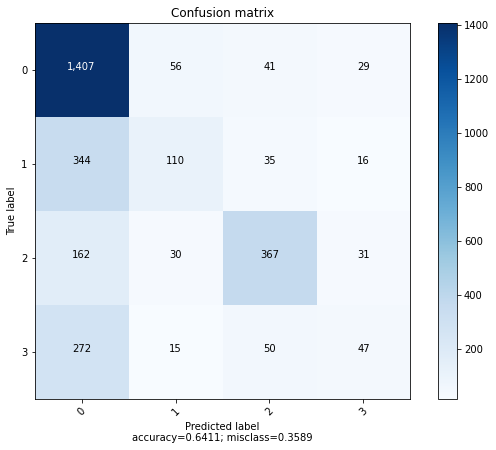

In [ ]:
plot_confusion_matrix(cm, [0,1,2,3],normalize=False)

## Train and Test Model (Cross Validation)

In [ ]:
# Do_Cross_Validation(model,padded_docs,comment_labels)
Do_Cross_Validation(padded_docs,comment_labels)

# Hyperparameter Tuning

In [ ]:
def tune_hyperparameters(model_build_fn):
  # fix random seed for reproducibility
  seed = 7
  np.random.seed(seed)

  model = KerasClassifier(build_fn=model_build_fn, maxlen=MAX_LEN, hidden_dims=HIDDEN_DIMS, l2_reg= L2_REG, verbose=VERBOSITY)

  # optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
  maxlen_list  = [210]
  hidden_dims_list = [300, 400, 500, 600]
  l2_reg_list = [0.01, 0.02]
  drop_out_value_list = [0.5, 0.8]
  # tune for kernal size 2,3,4,5


  param_grid = dict(maxlen=maxlen_list, hidden_dims = hidden_dims_list, l2_reg= l2_reg_list, drop_out_value = drop_out_value_list )
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=FOLDS, verbose = 10 )
  grid_result = grid.fit(padded_docs, comment_labels)

  # summarize results
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
# tune_hyperparameters(build_BiLSTM_model)